In [1]:
import time
import torch
from torch.utils.data import DataLoader, Dataset
import PIL
import os

from torchvision import transforms as transforms
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix
import pickle
import torch.nn.functional as F
import seaborn as sns
import sys
sys.path.append('../')
from utils import MHCoverDataset, get_dataloader
from pathlib import Path
from utils.training import TrainingInterface

In [2]:
train_df = pd.read_csv("../data/train_o.csv")
test_df = pd.read_csv("../data/test.csv")
val_df = pd.read_csv("../data/val.csv")

In [3]:
train_df

,image,set,label
0,100184900.png,train,Rost/Strassenrost
1,100034700.png,train,Rost/Strassenrost
2,100003200.png,train,Vollguss/Handgriff geschlossen
3,100004000.png,train,Gussbeton/Pickelloch belueftet
4,100125300.png,train,Vollguss/Handgriff geschlossen
...,...,...,...
1751,100067600.png,train,Rost/Strassenrost
1752,100188300.png,train,Vollguss/Pickelloch belueftet
1753,100090100.png,train,Vollguss/Pickelloch belueftet
1754,100004200.png,train,Rost/Strassenrost


In [58]:
my_train_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=45),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomPerspective(p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.RandomAutocontrast(p=0.2),
        transforms.ToTensor(),
    ]
)

In [59]:
my_test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)

In [6]:
trainloader = get_dataloader(
    root_dir="../data/train1/",
    df=train_df,
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=my_train_transforms,
    batch_size=16,
    workers=0,
    pin_memory=True,
    shuffle=True
)
valloader = get_dataloader(
    root_dir="../data/val1/",
    df=val_df,
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=my_train_transforms,
    batch_size=16,
    workers=0,
    pin_memory=True,
    shuffle=True
)
testloader = get_dataloader(
    root_dir="../data/test1/",
    df=pd.read_csv("../data/test.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=my_test_transforms,
    batch_size=16,
    workers=0,
    pin_memory=True,
    shuffle=True
)

In [92]:
def trainloader():
    trainloader = get_dataloader(
        root_dir="../data/train1/",
        df=train_df,
        fp_label_translator='../utils/dataset/label_translate.pkl',
        transformations=my_train_transforms,
        batch_size=16,
        workers=0,
        pin_memory=True,
        shuffle=True
    )
    return trainloader
def valloader():
    valloader = get_dataloader(
        root_dir="../data/val1/",
        df=val_df,
        fp_label_translator='../utils/dataset/label_translate.pkl',
        transformations=my_train_transforms,
        batch_size=16,
        workers=0,
        pin_memory=True,
        shuffle=True
    )
    return valloader

testloader = get_dataloader(
    root_dir="../data/test1/",
    df=pd.read_csv("../data/test.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=my_test_transforms,
    batch_size=16,
    workers=0,
    pin_memory=True,
    shuffle=True
)

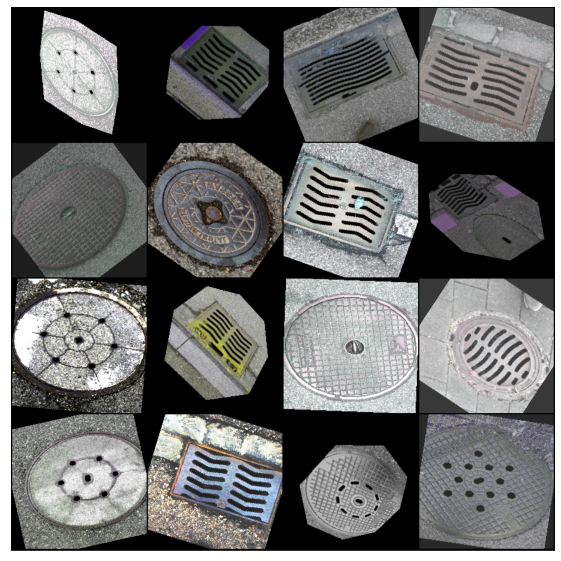

In [93]:
# Visualize one training batch
for images, labels in valloader():
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Networks

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
alexnet = models.alexnet(pretrained=False, progress=True)
alexnet = TrainingInterface(model=alexnet, name="alexnet")

In [11]:
resnet18 = models.resnet18(pretrained=False, progress=True)
resnet18 = TrainingInterface(model=resnet18, name="resnet18")

In [12]:
densenet121 = models.densenet121(pretrained=False, progress=True)
densenet121 = TrainingInterface(model=densenet121, name="densenet121")

In [13]:
vit_b_32 = models.vit_b_32(pretrained=False, progress=True)
vit_b_32 = TrainingInterface(model=vit_b_32, name="vit_b_32")

In [14]:
resnet101 = models.resnet101(pretrained=False, progress=True)
resnet101 = TrainingInterface(model=resnet101, name="resnet101")

In [15]:
convnext_large = models.convnext_large(pretrained=False, progress=True)
convnext_large = TrainingInterface(model=convnext_large, name="convnext_large")

## Funktions

In [16]:
def train(model, iterator, optimizer, criterion, device, regularizer = None):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()    
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        if regularizer == "L1":
            l1_l_c = nn.L1Loss()
            l1_lambda = 0.01
            l1_norm = 0
            for parameter in model.parameters():
                l1_norm += l1_l_c(parameter,target=torch.zeros_like(parameter))
            l1 = l1_lambda * l1_norm
            # Add L1 loss component
            loss += l1
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion, device, regularizer = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            if regularizer == "L1":
                l1_l_c = nn.L1Loss()
                l1_lambda = 0.01
                l1_norm = 0
                for parameter in model.parameters():
                    l1_norm += l1_l_c(parameter,target=torch.zeros_like(parameter))
                l1 = l1_lambda * l1_norm
                # Add L1 loss component
                loss += l1

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start, end):
    elapsed_time = end - start
    elapsed_in_min = int(elapsed_time / 60)
    elapsed_in_sec = int(elapsed_time - (elapsed_in_min * 60))
    return elapsed_in_min, elapsed_in_sec

In [19]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy

In [35]:
def train_epoch(epochs, model, trainloader,valloader, optimizer, criterion, device, regularizer = None):
   
    train_losses = []
    train_accuracy = []
    valid_losses = []
    valid_accuracy = []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        
        start_time = time.monotonic()

        train_loss, train_acc = train(model, trainloader, optimizer, criterion, device, regularizer = regularizer)
        valid_loss, valid_acc = evaluate(model, valloader, criterion, device, regularizer = regularizer)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracy.append(valid_acc)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s || Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% || Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return model, train_losses, train_accuracy, valid_losses, valid_accuracy

In [36]:
def metric_evaluation(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig = plt.subplots(figsize=(20, 5))
    plt.subplot(1,2,1)
    p1 = sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes,yticklabels=classes, cmap="YlGnBu")
    p1.set_title('Confusion Matrix')
    p1.set_ylabel('True')
    p1.set_xlabel('Predicted')

    plt.subplot(1,2,2)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    metric_names = ['Recall Macro', 'Precision Macro', 'F1 Macro']
    metrics = [recall, precision, f1]

    p2 = sns.barplot(x=metric_names, y=metrics,palette="Blues_d")
    for i, value in enumerate(metrics):
        plt.text(x=i, y=value, s=str(round(value,3)), ha='center')
    p2.set_ylim(0,1) 
    p2.set_title('metrics')
    p2.set_ylabel('Score')
    sns.despine()

    plt.show()

In [37]:
def get_predictions(model, iterator, device):
    
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [38]:
def loss_acc_function(train_loss,valid_loss,train_acc,valid_acc):
    
    fig = plt.subplots(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='Training loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(valid_acc, label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.show()

## Metrics

In [264]:
batch_size = 32
epochs = 50
num_workers = 0
learning_rate = 0.001

## AlexNet

In [155]:
model = alexnet.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(alexnet.model.parameters(), lr=learning_rate, momentum=0.9)

In [156]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 16s || Train Loss: 6.792 | Train Acc: 22.61% || Val. Loss: 6.564 |  Val. Acc: 26.44%
Epoch: 02 | Epoch Time: 0m 15s || Train Loss: 3.216 | Train Acc: 19.64% || Val. Loss: 2.284 |  Val. Acc: 26.44%
Epoch: 03 | Epoch Time: 0m 16s || Train Loss: 2.346 | Train Acc: 22.27% || Val. Loss: 2.398 |  Val. Acc: 17.79%
Epoch: 04 | Epoch Time: 0m 16s || Train Loss: 2.275 | Train Acc: 23.22% || Val. Loss: 2.172 |  Val. Acc: 26.44%
Epoch: 05 | Epoch Time: 0m 16s || Train Loss: 2.142 | Train Acc: 27.03% || Val. Loss: 2.167 |  Val. Acc: 26.44%
Epoch: 06 | Epoch Time: 0m 16s || Train Loss: 1.949 | Train Acc: 37.99% || Val. Loss: 1.903 |  Val. Acc: 41.83%
Epoch: 07 | Epoch Time: 0m 16s || Train Loss: 1.804 | Train Acc: 41.84% || Val. Loss: 1.700 |  Val. Acc: 43.75%
Epoch: 08 | Epoch Time: 0m 15s || Train Loss: 1.706 | Train Acc: 42.65% || Val. Loss: 1.667 |  Val. Acc: 44.23%
Epoch: 09 | Epoch Time: 0m 15s || Train Loss: 1.653 | Train Acc: 44.17% || Val. Loss: 1.722 |  Val. Acc:

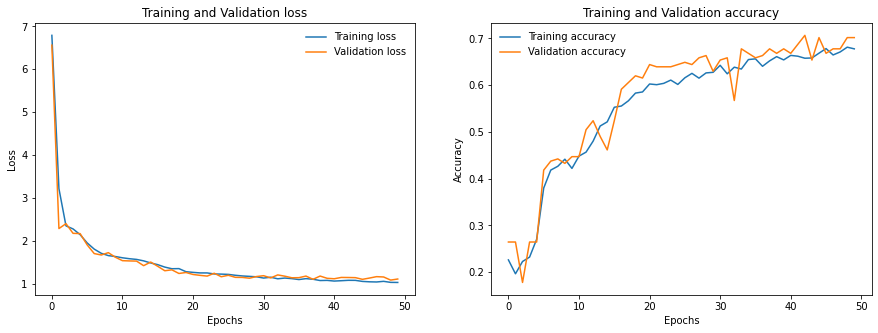

In [157]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [158]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.866 | Test Acc: 73.66%


In [159]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [160]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [161]:
classes = list(label_dict)

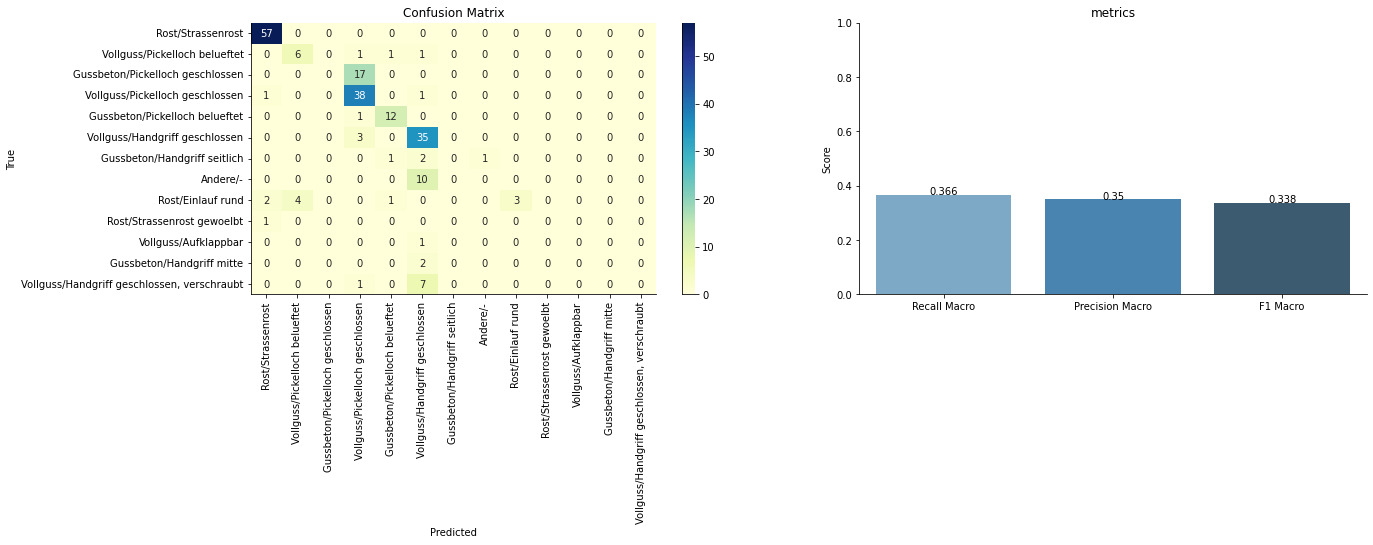

In [162]:
metric_evaluation(labels, pred_labels)

## Resnet18

In [163]:
model = resnet18.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet18.model.parameters(), lr=learning_rate, momentum=0.9)

In [164]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 19s || Train Loss: 2.604 | Train Acc: 37.39% || Val. Loss: 1.753 |  Val. Acc: 44.71%
Epoch: 02 | Epoch Time: 0m 19s || Train Loss: 1.632 | Train Acc: 44.58% || Val. Loss: 2.290 |  Val. Acc: 29.81%
Epoch: 03 | Epoch Time: 0m 18s || Train Loss: 1.510 | Train Acc: 48.83% || Val. Loss: 1.518 |  Val. Acc: 48.08%
Epoch: 04 | Epoch Time: 0m 19s || Train Loss: 1.409 | Train Acc: 52.73% || Val. Loss: 1.354 |  Val. Acc: 50.00%
Epoch: 05 | Epoch Time: 0m 19s || Train Loss: 1.272 | Train Acc: 58.50% || Val. Loss: 1.544 |  Val. Acc: 48.08%
Epoch: 06 | Epoch Time: 0m 18s || Train Loss: 1.134 | Train Acc: 65.61% || Val. Loss: 1.804 |  Val. Acc: 56.25%
Epoch: 07 | Epoch Time: 0m 18s || Train Loss: 1.038 | Train Acc: 69.41% || Val. Loss: 1.285 |  Val. Acc: 61.54%
Epoch: 08 | Epoch Time: 0m 18s || Train Loss: 0.985 | Train Acc: 69.89% || Val. Loss: 1.030 |  Val. Acc: 70.19%
Epoch: 09 | Epoch Time: 0m 18s || Train Loss: 0.962 | Train Acc: 72.88% || Val. Loss: 0.893 |  Val. Acc:

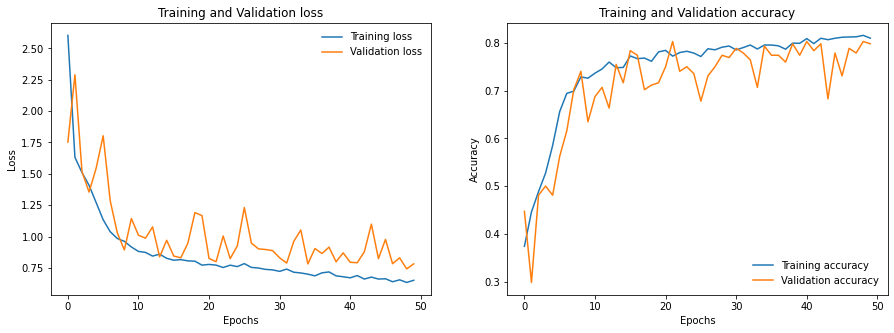

In [165]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [166]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.503 | Test Acc: 86.16%


In [167]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [168]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [169]:
classes = list(label_dict)

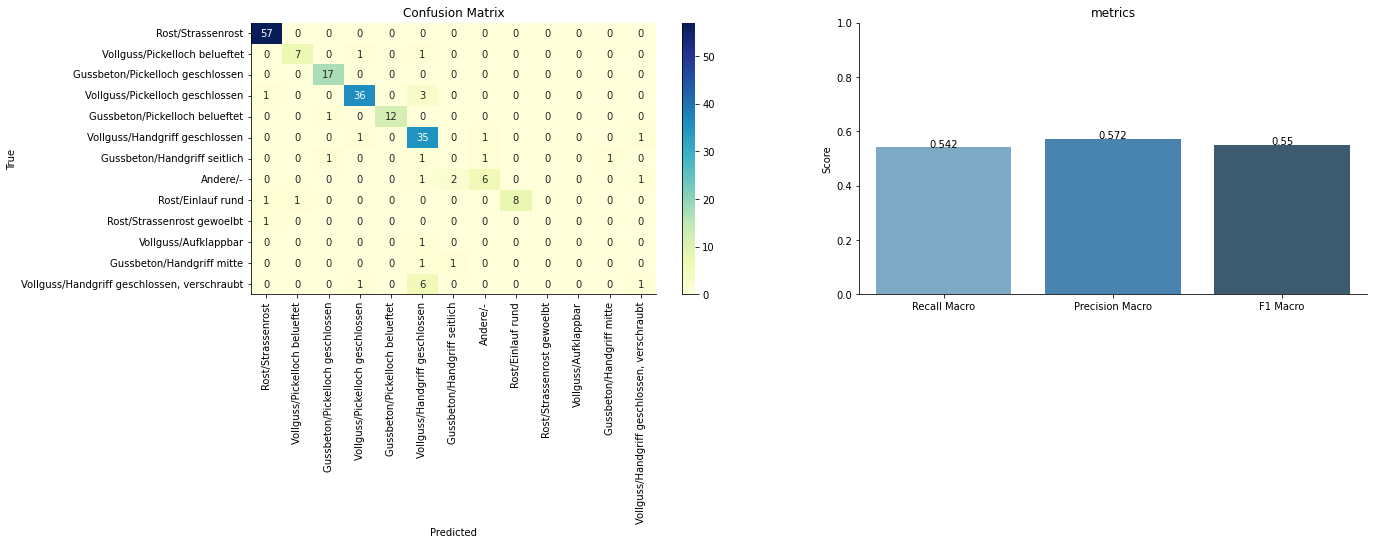

In [170]:
metric_evaluation(labels, pred_labels)

## DenseNet121

In [171]:
model = densenet121.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(densenet121.model.parameters(), lr=learning_rate, momentum=0.9)

In [172]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 27s || Train Loss: 3.202 | Train Acc: 35.72% || Val. Loss: 1.990 |  Val. Acc: 43.75%
Epoch: 02 | Epoch Time: 0m 26s || Train Loss: 1.816 | Train Acc: 44.15% || Val. Loss: 1.687 |  Val. Acc: 48.08%
Epoch: 03 | Epoch Time: 0m 26s || Train Loss: 1.656 | Train Acc: 45.40% || Val. Loss: 1.563 |  Val. Acc: 44.71%
Epoch: 04 | Epoch Time: 0m 26s || Train Loss: 1.547 | Train Acc: 48.69% || Val. Loss: 1.537 |  Val. Acc: 48.08%
Epoch: 05 | Epoch Time: 0m 26s || Train Loss: 1.451 | Train Acc: 50.81% || Val. Loss: 1.417 |  Val. Acc: 49.04%
Epoch: 06 | Epoch Time: 0m 26s || Train Loss: 1.390 | Train Acc: 54.64% || Val. Loss: 1.411 |  Val. Acc: 56.73%
Epoch: 07 | Epoch Time: 0m 26s || Train Loss: 1.345 | Train Acc: 56.46% || Val. Loss: 1.479 |  Val. Acc: 50.96%
Epoch: 08 | Epoch Time: 0m 26s || Train Loss: 1.296 | Train Acc: 56.57% || Val. Loss: 1.281 |  Val. Acc: 57.21%
Epoch: 09 | Epoch Time: 0m 26s || Train Loss: 1.244 | Train Acc: 59.07% || Val. Loss: 1.230 |  Val. Acc:

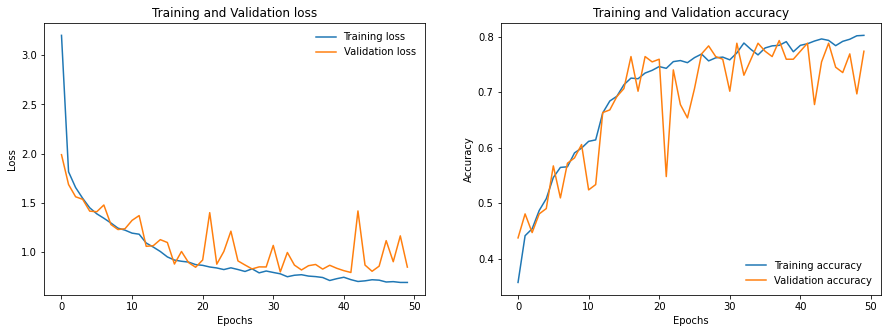

In [173]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [174]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.578 | Test Acc: 82.14%


In [175]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [176]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [177]:
classes = list(label_dict)

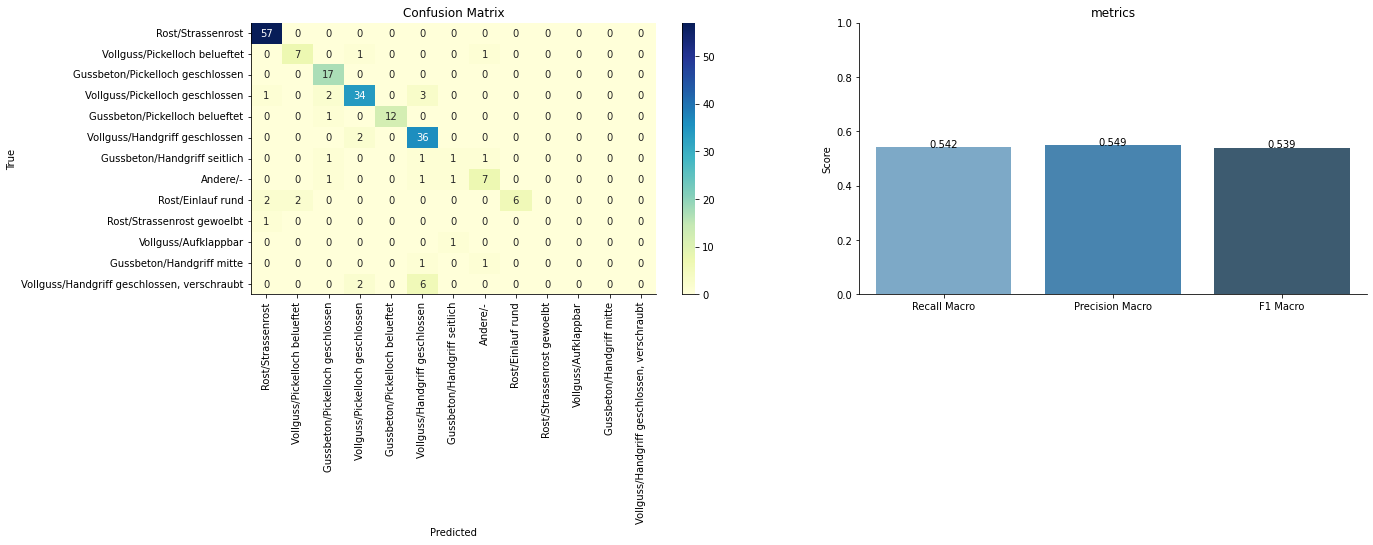

In [178]:
metric_evaluation(labels, pred_labels)

## Resnet101

In [99]:
batch_size = 32
epochs = 100
num_workers = 0
learning_rate = 0.005

In [100]:
model = resnet101.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet101.model.parameters(), lr=learning_rate, momentum=0.9)

In [101]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader(), valloader(), optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 43s || Train Loss: 1.317 | Train Acc: 65.49% || Val. Loss: 1.787 |  Val. Acc: 58.17%
Epoch: 02 | Epoch Time: 0m 39s || Train Loss: 1.217 | Train Acc: 67.12% || Val. Loss: 1.601 |  Val. Acc: 67.79%
Epoch: 03 | Epoch Time: 0m 39s || Train Loss: 1.247 | Train Acc: 68.67% || Val. Loss: 1.236 |  Val. Acc: 73.56%
Epoch: 04 | Epoch Time: 0m 39s || Train Loss: 0.999 | Train Acc: 72.27% || Val. Loss: 1.106 |  Val. Acc: 68.27%
Epoch: 05 | Epoch Time: 0m 39s || Train Loss: 1.030 | Train Acc: 71.21% || Val. Loss: 1.888 |  Val. Acc: 67.31%
Epoch: 06 | Epoch Time: 0m 39s || Train Loss: 0.978 | Train Acc: 73.86% || Val. Loss: 1.325 |  Val. Acc: 72.12%
Epoch: 07 | Epoch Time: 0m 39s || Train Loss: 0.952 | Train Acc: 73.14% || Val. Loss: 0.937 |  Val. Acc: 75.00%
Epoch: 08 | Epoch Time: 0m 39s || Train Loss: 0.989 | Train Acc: 73.94% || Val. Loss: 1.014 |  Val. Acc: 72.12%
Epoch: 09 | Epoch Time: 0m 39s || Train Loss: 0.963 | Train Acc: 72.58% || Val. Loss: 1.082 |  Val. Acc:

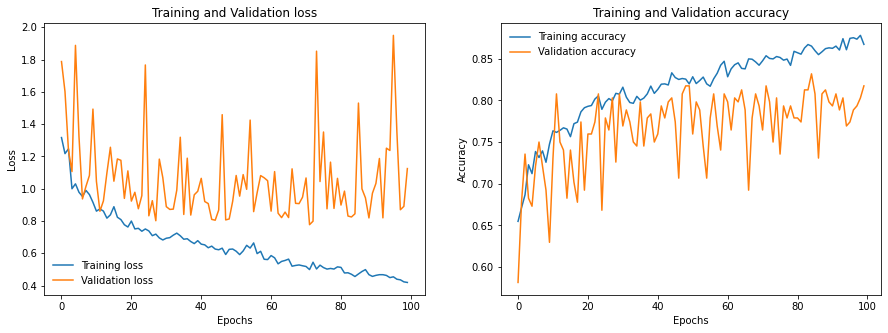

In [102]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [103]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.903 | Test Acc: 87.50%


In [104]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [105]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [106]:
classes = list(label_dict)

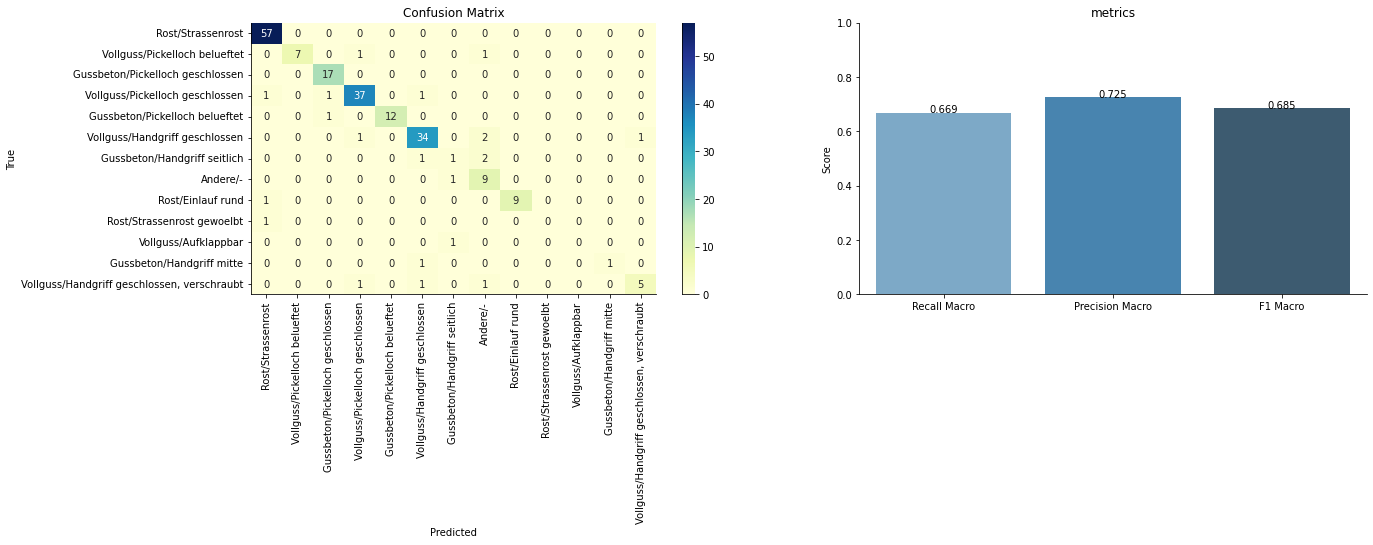

In [107]:
metric_evaluation(labels, pred_labels)

## Resnet101 Test 2

In [108]:
batch_size = 32
epochs = 100
num_workers = 0
learning_rate = 0.01

In [110]:
model = resnet101.model
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(resnet101.model.parameters(), lr=learning_rate)

In [111]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader(),valloader(), optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 42s || Train Loss: 3.328 | Train Acc: 24.58% || Val. Loss: 5.077 |  Val. Acc: 20.19%
Epoch: 02 | Epoch Time: 0m 41s || Train Loss: 2.015 | Train Acc: 34.43% || Val. Loss: 1.847 |  Val. Acc: 34.62%
Epoch: 03 | Epoch Time: 0m 41s || Train Loss: 1.844 | Train Acc: 38.60% || Val. Loss: 1.965 |  Val. Acc: 39.42%
Epoch: 04 | Epoch Time: 0m 41s || Train Loss: 1.782 | Train Acc: 40.19% || Val. Loss: 1.759 |  Val. Acc: 41.83%
Epoch: 05 | Epoch Time: 0m 41s || Train Loss: 1.727 | Train Acc: 40.66% || Val. Loss: 1.789 |  Val. Acc: 41.83%
Epoch: 06 | Epoch Time: 0m 41s || Train Loss: 1.717 | Train Acc: 41.02% || Val. Loss: 1.689 |  Val. Acc: 43.75%
Epoch: 07 | Epoch Time: 0m 41s || Train Loss: 1.651 | Train Acc: 42.27% || Val. Loss: 1.712 |  Val. Acc: 45.67%
Epoch: 08 | Epoch Time: 0m 41s || Train Loss: 1.635 | Train Acc: 44.03% || Val. Loss: 2.093 |  Val. Acc: 34.13%
Epoch: 09 | Epoch Time: 0m 41s || Train Loss: 1.589 | Train Acc: 45.89% || Val. Loss: 1.703 |  Val. Acc:

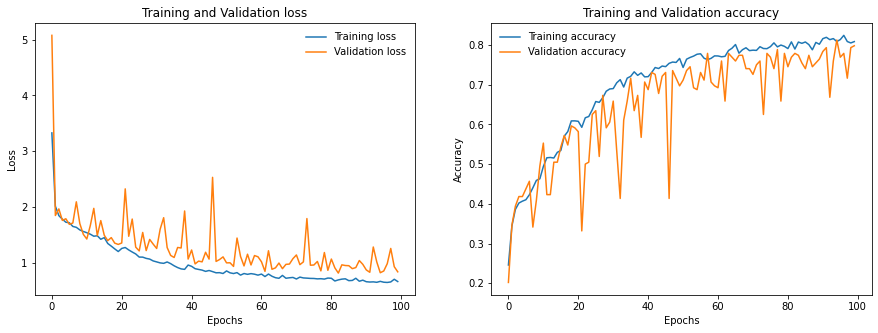

In [112]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [113]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.586 | Test Acc: 83.04%


In [114]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [115]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [116]:
classes = list(label_dict)

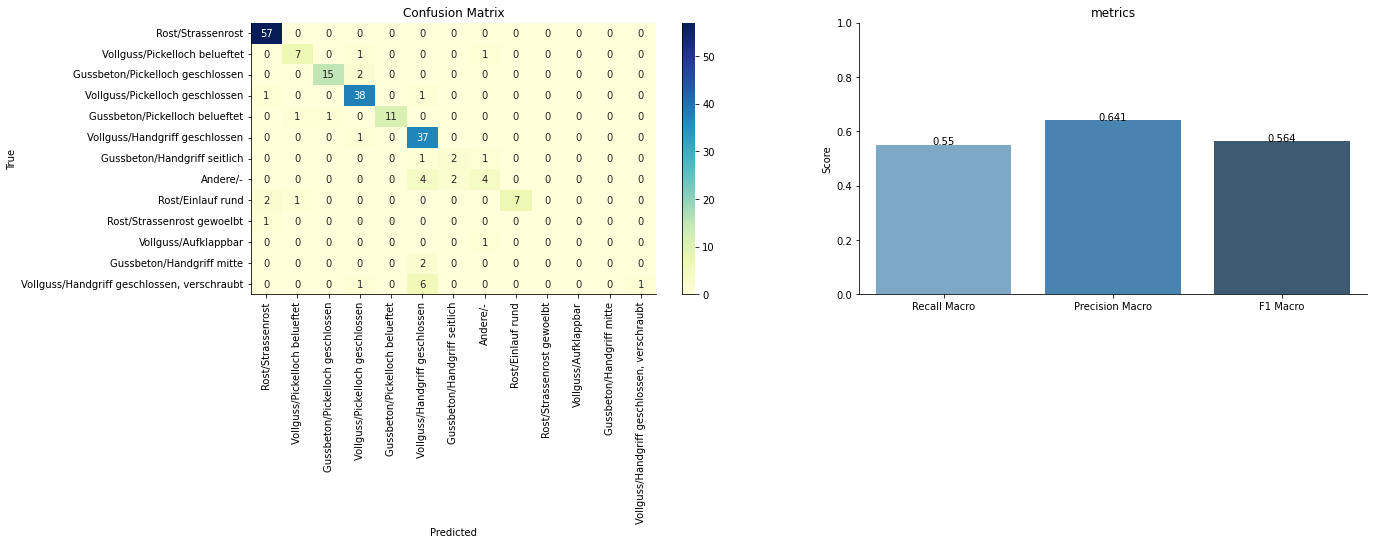

In [117]:
metric_evaluation(labels, pred_labels)

## Simple Net test

In [72]:
def trainloader():
    trainloader = get_dataloader(
        root_dir="../data/train1/",
        df=train_df,
        fp_label_translator='../utils/dataset/label_translate.pkl',
        transformations=my_test_transforms,
        batch_size=16,
        workers=0,
        pin_memory=True,
        shuffle=True
    )
    return trainloader
def valloader():
    valloader = get_dataloader(
        root_dir="../data/val1/",
        df=val_df,
        fp_label_translator='../utils/dataset/label_translate.pkl',
        transformations=my_test_transforms,
        batch_size=16,
        workers=0,
        pin_memory=True,
        shuffle=True
    )
    return valloader

testloader = get_dataloader(
    root_dir="../data/test1/",
    df=pd.read_csv("../data/test.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=my_test_transforms,
    batch_size=16,
    workers=0,
    pin_memory=True,
    shuffle=True
)

In [73]:
batch_size = 32
epochs = 50
num_workers = 0
learning_rate = 0.001

In [74]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [75]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader(),valloader(), optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 12s || Train Loss: 2.260 | Train Acc: 23.67% || Val. Loss: 2.125 |  Val. Acc: 35.10%
Epoch: 02 | Epoch Time: 0m 13s || Train Loss: 2.035 | Train Acc: 31.36% || Val. Loss: 2.080 |  Val. Acc: 32.21%
Epoch: 03 | Epoch Time: 0m 13s || Train Loss: 1.865 | Train Acc: 37.18% || Val. Loss: 1.777 |  Val. Acc: 42.31%
Epoch: 04 | Epoch Time: 0m 14s || Train Loss: 1.660 | Train Acc: 43.86% || Val. Loss: 1.613 |  Val. Acc: 45.67%
Epoch: 05 | Epoch Time: 0m 13s || Train Loss: 1.567 | Train Acc: 47.50% || Val. Loss: 1.598 |  Val. Acc: 44.71%
Epoch: 06 | Epoch Time: 0m 13s || Train Loss: 1.502 | Train Acc: 47.35% || Val. Loss: 1.505 |  Val. Acc: 47.60%
Epoch: 07 | Epoch Time: 0m 13s || Train Loss: 1.465 | Train Acc: 48.50% || Val. Loss: 1.486 |  Val. Acc: 48.56%
Epoch: 08 | Epoch Time: 0m 13s || Train Loss: 1.423 | Train Acc: 50.40% || Val. Loss: 1.455 |  Val. Acc: 48.08%
Epoch: 09 | Epoch Time: 0m 13s || Train Loss: 1.395 | Train Acc: 52.01% || Val. Loss: 1.391 |  Val. Acc:

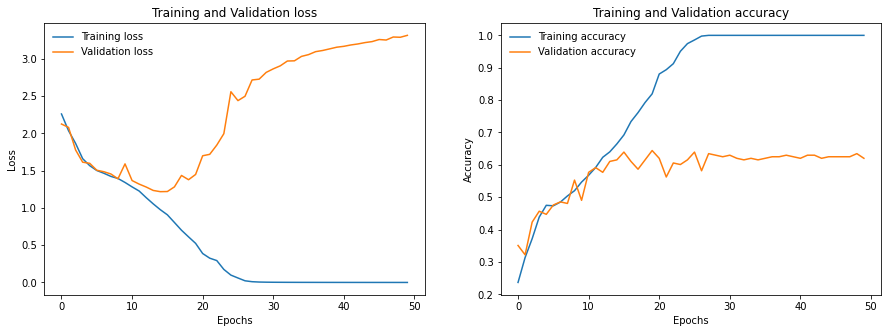

In [76]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [77]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 3.320 | Test Acc: 59.82%


In [78]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [79]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [80]:
classes = list(label_dict)

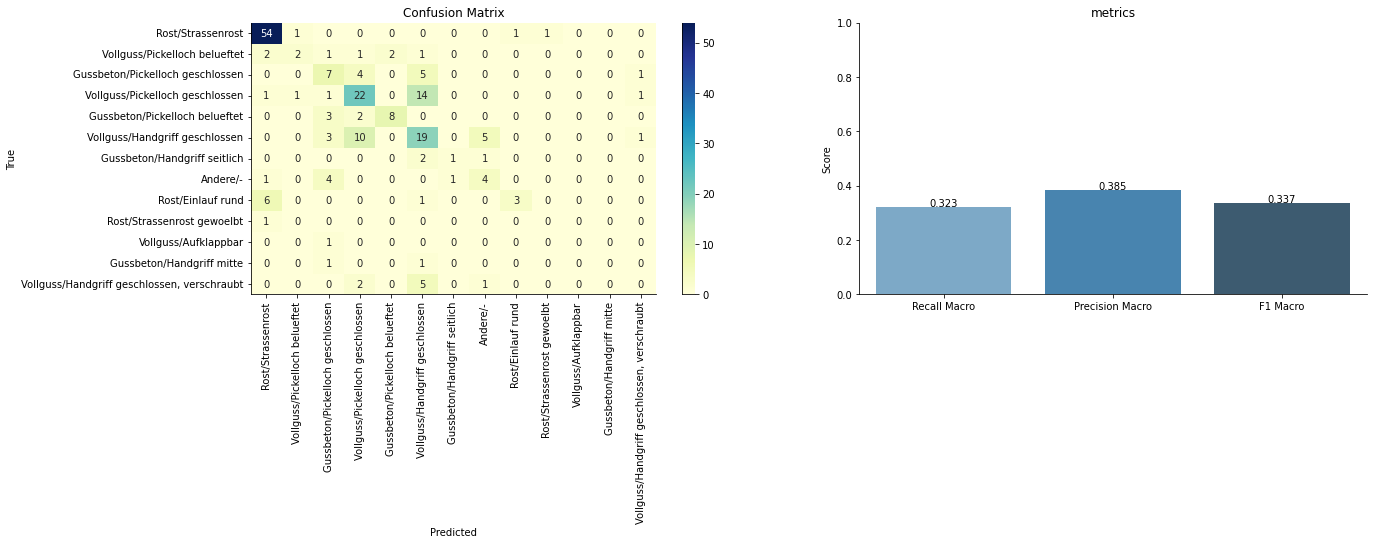

In [81]:
metric_evaluation(labels, pred_labels)

In [82]:
def trainloader():
    trainloader = get_dataloader(
        root_dir="../data/train1/",
        df=train_df,
        fp_label_translator='../utils/dataset/label_translate.pkl',
        transformations=my_train_transforms,
        batch_size=16,
        workers=0,
        pin_memory=True,
        shuffle=True
    )
    return trainloader
def valloader():
    valloader = get_dataloader(
        root_dir="../data/val1/",
        df=val_df,
        fp_label_translator='../utils/dataset/label_translate.pkl',
        transformations=my_train_transforms,
        batch_size=16,
        workers=0,
        pin_memory=True,
        shuffle=True
    )
    return valloader

testloader = get_dataloader(
    root_dir="../data/test1/",
    df=pd.read_csv("../data/test.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=my_test_transforms,
    batch_size=16,
    workers=0,
    pin_memory=True,
    shuffle=True
)

In [83]:
batch_size = 32
epochs = 50
num_workers = 0
learning_rate = 0.001

In [84]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [85]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader(),valloader(), optimizer, criterion, device)

Epoch: 01 | Epoch Time: 0m 24s || Train Loss: 2.277 | Train Acc: 22.80% || Val. Loss: 2.133 |  Val. Acc: 19.71%
Epoch: 02 | Epoch Time: 0m 24s || Train Loss: 2.172 | Train Acc: 24.75% || Val. Loss: 2.143 |  Val. Acc: 27.88%
Epoch: 03 | Epoch Time: 0m 24s || Train Loss: 2.134 | Train Acc: 26.93% || Val. Loss: 2.115 |  Val. Acc: 28.85%
Epoch: 04 | Epoch Time: 0m 24s || Train Loss: 2.098 | Train Acc: 27.95% || Val. Loss: 2.014 |  Val. Acc: 32.69%
Epoch: 05 | Epoch Time: 0m 24s || Train Loss: 2.008 | Train Acc: 31.91% || Val. Loss: 1.955 |  Val. Acc: 35.10%
Epoch: 06 | Epoch Time: 0m 24s || Train Loss: 1.904 | Train Acc: 35.61% || Val. Loss: 1.749 |  Val. Acc: 43.27%
Epoch: 07 | Epoch Time: 0m 24s || Train Loss: 1.724 | Train Acc: 41.29% || Val. Loss: 1.704 |  Val. Acc: 45.19%
Epoch: 08 | Epoch Time: 0m 24s || Train Loss: 1.705 | Train Acc: 41.44% || Val. Loss: 1.685 |  Val. Acc: 44.23%
Epoch: 09 | Epoch Time: 0m 24s || Train Loss: 1.644 | Train Acc: 43.31% || Val. Loss: 1.763 |  Val. Acc:

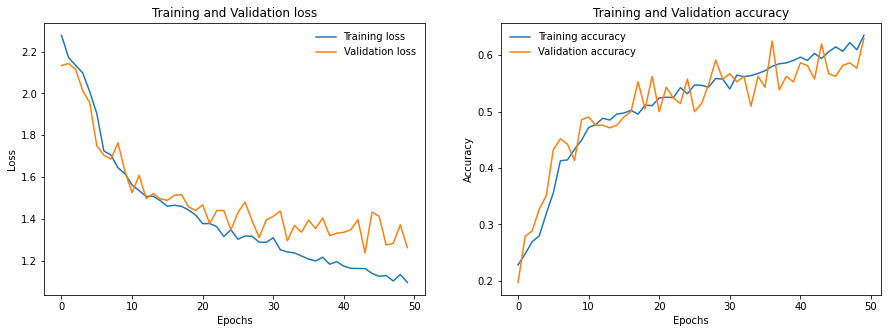

In [86]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

In [87]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.856 | Test Acc: 76.34%


In [88]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

In [89]:
with open('../utils/dataset/label_translate.pkl', 'rb') as pkl_file:
    label_dict = pickle.load(pkl_file)

In [90]:
classes = list(label_dict)

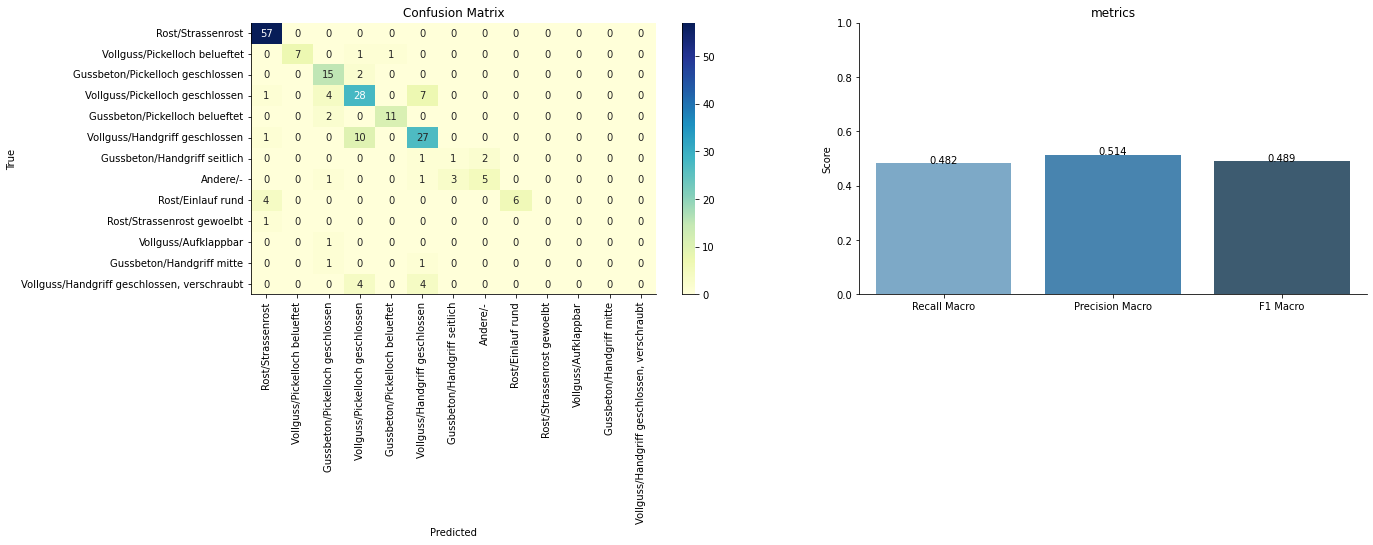

In [91]:
metric_evaluation(labels, pred_labels)